In [1]:
!pip install kaggle

# Upload your Kaggle API token
from google.colab import files
files.upload()

# Create directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d muhriddinmuxiddinov/fruits-and-vegetables-dataset


!unzip -o fruits-and-vegetables-dataset.zip -d /content/dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (444).jpg  
  inflating: /content/dataset/Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (445).jpg  
  inflating: /content/dataset/Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (446).JPG  
  inflating: /content/dataset/Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (447).jpg  
  inflating: /content/dataset/Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (448).jpg  
  inflating: /content/dataset/Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (449).jpg  
  inflating: /content/dataset/Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (45).jpg  
  inflating: /content/dataset/Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (450).jpg  
  inflating: /content/dataset/Fruits_Vegetables_Dataset(12000)/Vegetab

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import LearningRateScheduler
from PIL import Image


class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, image_size=(224, 224)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = [self.image_paths[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        X = np.array([self.load_image(image_path) for image_path in batch_images])

        y_fruit_veg = np.array([label[0] for label in batch_labels])
        y_fruit_veg_type = np.array([label[1] for label in batch_labels])
        y_fresh_rotten = np.array([label[2] for label in batch_labels])

        y_fruit_veg = tf.keras.utils.to_categorical(y_fruit_veg, num_classes=2)
        y_fruit_veg_type = tf.keras.utils.to_categorical(y_fruit_veg_type, num_classes=10)
        y_fresh_rotten = tf.keras.utils.to_categorical(y_fresh_rotten, num_classes=2)

        return X, {
            'fruit_veg': y_fruit_veg,
            'fruit_veg_type': y_fruit_veg_type,
            'fresh_rotten': y_fresh_rotten
        }

    def load_image(self, path):
        try:
            image = Image.open(path).convert('RGB')
            image = image.resize(self.image_size)
            image = np.array(image) / 255.0
            return image
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            return np.zeros((self.image_size[0], self.image_size[1], 3))

def load_data(dataset_path):
    image_paths = []
    labels = []

    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)

        if os.path.isdir(category_path):
            for subcategory in os.listdir(category_path):
                subcategory_path = os.path.join(category_path, subcategory)

                if os.path.isdir(subcategory_path):
                    for freshness in os.listdir(subcategory_path):
                        freshness_path = os.path.join(subcategory_path, freshness)

                        if os.path.isdir(freshness_path):
                            for filename in os.listdir(freshness_path):
                                file_path = os.path.join(freshness_path, filename)

                                if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                                    image_paths.append(file_path)

                                    fruit_veg_label = 0 if category.lower() == 'fruits' else 1
                                    type_label = get_type_label(subcategory.lower())
                                    fresh_rotten_label = 0 if 'fresh' in freshness.lower() else 1

                                    labels.append([fruit_veg_label, type_label, fresh_rotten_label])

    return image_paths, labels

def get_type_label(subcategory):
    types = ['apple', 'banana', 'strawberry', 'mango', 'orange', 'bellpepper', 'carrot', 'cucumber', 'potato', 'tomato']
    return types.index(subcategory) if subcategory in types else -1

dataset_path = '/content/dataset/'
image_paths, labels = load_data(dataset_path)

if len(image_paths) == 0 or len(labels) == 0:
    raise ValueError("No images or labels found. Please check the dataset path and structure.")

train_generator = CustomDataGenerator(image_paths, labels)

# Load the MobileNetV2 base model and create a multi-output model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

fruit_veg_output = layers.Dense(2, activation='softmax', name='fruit_veg')(x)
num_fruit_veg_types = 10
fruit_veg_type_output = layers.Dense(num_fruit_veg_types, activation='softmax', name='fruit_veg_type')(x)
fresh_rotten_output = layers.Dense(2, activation='sigmoid', name='fresh_rotten')(x)

model = models.Model(inputs=base_model.input, outputs=[fruit_veg_output, fruit_veg_type_output, fresh_rotten_output])

model.compile(optimizer='adam',
              loss={'fruit_veg': 'categorical_crossentropy',
                    'fruit_veg_type': 'categorical_crossentropy',
                    'fresh_rotten': 'binary_crossentropy'},
              metrics={
                  'fruit_veg': 'accuracy',
                  'fruit_veg_type': 'accuracy',
                  'fresh_rotten': 'accuracy'
              })

def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    elif epoch < 6:
        return lr * 0.5
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(scheduler)

steps_per_epoch = len(image_paths) // train_generator.batch_size

history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_scheduler]
)

print("Training completed.")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


374/374 ━━━━━━━━━━━━━━━━━━━━ 635s 2s/step - fresh_rotten_accuracy: 0.8265 - fruit_veg_accuracy: 0.9775 - fruit_veg_type_accuracy: 0.9717 - loss: 0.5396 - learning_rate: 0.0010
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 95us/step - fresh_rotten_accuracy: 0.9688 - fruit_veg_accuracy: 1.0000 - fruit_veg_type_accuracy: 1.0000 - loss: 0.1177 - learning_rate: 0.0010
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


374/374 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - fresh_rotten_accuracy: 0.9385 - fruit_veg_accuracy: 1.0000 - fruit_veg_type_accuracy: 1.0000 - loss: 0.1793 - learning_rate: 0.0010
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 49us/step - fresh_rotten_accuracy: 0.9688 - fruit_veg_accuracy: 1.0000 - fruit_veg_type_accuracy: 1.0000 - loss: 0.1292 - learning_rate: 5.0000e-04
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 606s 2s/step - fresh_rotten_accuracy: 0.9461 - fruit_veg_accuracy: 1.0000 - fruit_veg_type_accuracy: 1.0000 - loss: 0.1572 - learning_rate: 2.5000e-04
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 45us/step - fresh_rotten_accuracy: 0.9375 - fruit_veg_accuracy: 1.0000 - fruit_veg_type_accuracy: 1.0000 - loss: 0.1895 - learning_rate: 1.2500e-04
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - fresh_rotten_accuracy: 0.9493 - fruit_veg_accuracy: 1.0000 - fruit_veg_type_accuracy: 1.0000 - loss: 0.1528 - learning_rate: 1.2500e-05
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 80us/step - fresh

In [8]:


# Evaluate the model

loss, fresh_rotten_accuracy, fruit_veg_accuracy, fruit_veg_type_accuracy = model.evaluate(train_generator)

print(f"Test Loss: {loss}")
print(f"Fresh/Roasted Accuracy: {fresh_rotten_accuracy}")


# Save the model
model.save('fruit_veg_freshness_model.h5')  # Save the model in HDF5 format
print("Model saved successfully.")


375/375 ━━━━━━━━━━━━━━━━━━━━ 606s 2s/step - fresh_rotten_accuracy: 0.9499 - fruit_veg_accuracy: 1.0000 - fruit_veg_type_accuracy: 1.0000 - loss: 0.1439


Test Loss: 0.14914044737815857
Fresh/Roasted Accuracy: 0.949524462223053
Model saved successfully.


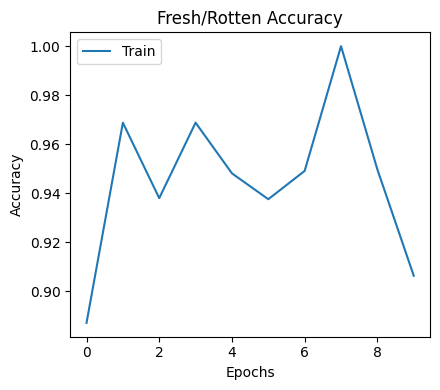

In [9]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 4))

# Plot Fresh/Rotten Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['fresh_rotten_accuracy'], label='Train')
plt.title('Fresh/Rotten Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()



plt.tight_layout()
plt.show()
